In [1]:
from trainer.trainer import CWPTT
import matplotlib.pyplot as plt
n_debris = 3
trainer = CWPTT(n_debris, "cuda")
# trainer.agent.load("../model/planTrack.ptd")
trainer.agent.load(f"../model/planTrack{n_debris}.ptd")

In [8]:
results = trainer.trainUnity(3600, epoch=1, batch_size=128)

Output()

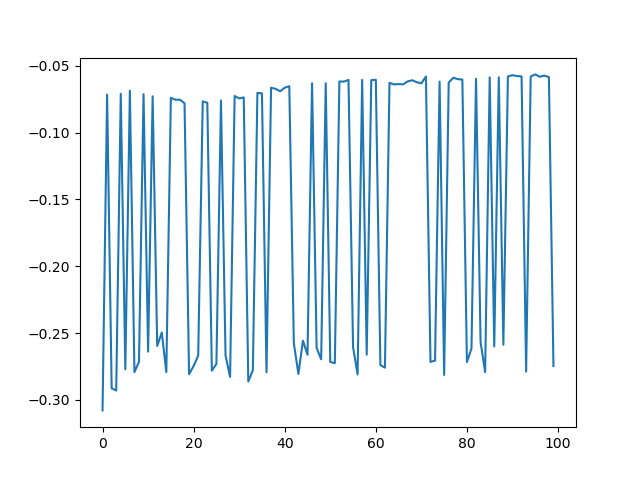

In [25]:
plt.close("all")
plt.plot(results[3])
plt.show()

In [ ]:
ll = trainer.trainTracker(1200,)
trainer.agent.save("../model/planTrack.ptd")
plt.close("all")
plt.plot(ll)
plt.show()

In [ ]:
al, cl, tr = trainer.trainPlaner(episode=1000, epoch=10)
trainer.agent.save("../model/planTrack.ptd")
plt.close("all")
plt.plot(tr)
plt.show()

In [326]:
horizon = 3600
n = 10
win = 0
for _ in range(n):
    d, stage = trainer.test(horizon, "static")
    if stage==horizon-1:
        win += 1
print(win/n)

0.9


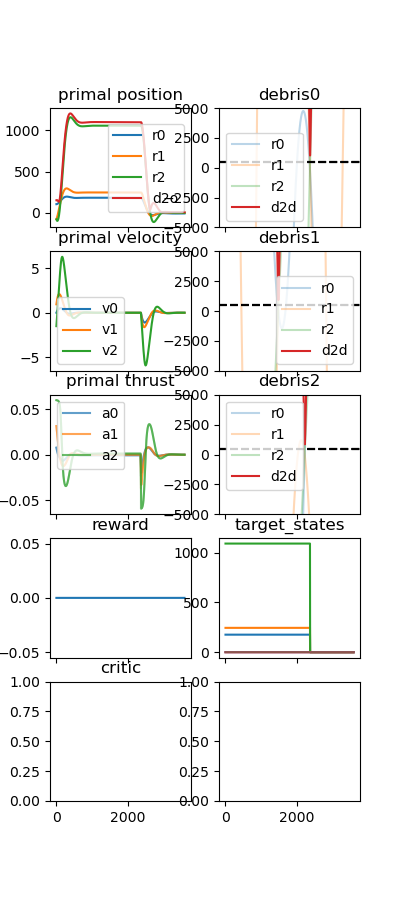

In [324]:
from plotting.analyze import *
%matplotlib widget
horizon = 3600
d, stage = trainer.test(horizon, "static")
plt.close('all')
# n_debris = 0
n_debris = trainer.mainProp.n_debris
fig, _ = historyFile(d, agent=None, stage=stage, n_debris=n_debris, items=("target_states",))

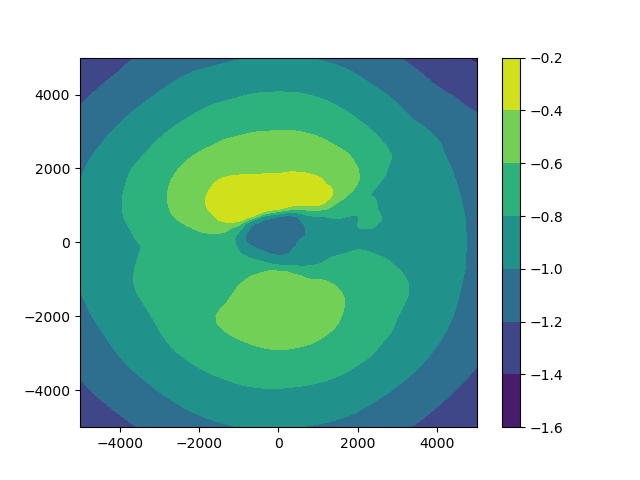

In [322]:
import numpy as np
from plotting import analyze
import torch
s = trainer.mainProp.randomInitStates(1)
o = trainer.mainProp.getObss(s)
o_a = np.hstack((o.flatten(), np.zeros(trainer.agent.control_dim)))

n_f = trainer.agent.critic.n_feature
axis = np.array([0,2])
axis.sort()
dims = n_f-(3-axis)
o_a_ = np.delete(o_a, dims)

plt.close("all")
analyze.criticContour(trainer.agent, span=(-5000,5000), dims=dims, step=101, singles=o_a_)

target = trainer.agent.planner(torch.from_numpy(o).float().to(trainer.agent.device))
target = target.detach().cpu().numpy().flatten()
_ = plt.scatter(target[axis[0]], target[axis[1]], c="r")
# plt.show()